### Import libraries

In [1]:
#nltk.download()
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
#from sklearn.metrics import classification_report

#from sklearn import grid_search

### Import data 

In [2]:
df = pd.read_json("../data/train.json")
testdf = pd.read_json("../data/test.json") 

### Clean dataframe

In [3]:
df['ingredients_clean_string'] = [' , '.join(z).strip() for z in df['ingredients']]  
df['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in df['ingredients']]       

In [5]:
testdf['ingredients_clean_string'] = [' , '.join(z).strip() for z in testdf['ingredients']]
testdf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in testdf['ingredients']]       

In [6]:
#number of rows
print(len(df.index))

#view data
df.head()

39774


,cuisine,id,ingredients,ingredients_clean_string,ingredients_string
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce , black olives , grape tomatoe...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour , ground pepper , salt , tomatoes ...",plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs , pepper , salt , mayonaise , cooking oil...",egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]","water , vegetable oil , wheat , salt",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper , shallots , cornflour , cayenne ...",black pepper shallot cornflour cayenne pepper ...


### Model Creation

In [8]:
#instantiate vectorizer
vect = TfidfVectorizer(stop_words = 'english', #remove standard english stop words
                               ngram_range = (1 , 1), #range of n-values for different n-grams to be extracted
                               analyzer = "word", #feature made of word (not character) n-grams
                               max_df = .57, #ignore terms that have a document frequency higher than threshold 
                               binary = False , 
                               token_pattern = r'\w+' , #what constitutes a “token”
                               sublinear_tf = False
                              )

In [9]:
#use vectorizer on training corpus
predictors = vect.fit_transform(df['ingredients_string']).todense()

#define targets
response = df['cuisine']

In [10]:
#view features 
vect.get_feature_names()[1:5]

['abbamele', 'absinthe', 'abura', 'acai']

In [10]:
#classifier = LinearSVC(C=0.80, penalty="l2", dual=False)
parameters = {'C':[1, 10]}

#instantiate model
#clf = LinearSVC()
clf = LogisticRegression()
#model = MultinomialNB()

#train the model
classifier = GridSearchCV(clf, parameters)
classifier = classifier.fit(predictors, response) 

### Predict cuisine for test dataframe

In [11]:
#use vectorizer on test corpus
predictors_ts = vect.transform(testdf['ingredients_string'])

In [12]:
#make class predictions for test
predictions = classifier.predict(predictors_ts)

#add predictions to the dataframe
testdf['cuisine'] = predictions
testdf = testdf.sort_values('id', ascending=True)
testdf.head()

#testdf[['id' , 'ingredients_clean_string' , 'cuisine' ]].to_csv("submission.csv")

# A combination of Word lemmatization + LinearSVC model finally pushes the accuracy score past 80%

,id,ingredients,ingredients_clean_string,ingredients_string,cuisine
4987,5,"[mushrooms, chopped onion, tomato sauce, chees...","mushrooms , chopped onion , tomato sauce , che...",mushroom chopped onion tomato sauce cheese dri...,mexican
9232,7,"[minced garlic, brown rice, sour cream, chicke...","minced garlic , brown rice , sour cream , chic...",minced garlic brown rice sour cream chicken re...,indian
9638,11,"[lime juice, sesame oil, garlic cloves, fish s...","lime juice , sesame oil , garlic cloves , fish...",lime juice sesame oil garlic cloves fish sauce...,vietnamese
4927,12,"[sugar, vanilla extract, corn starch, coffee g...","sugar , vanilla extract , corn starch , coffee...",sugar vanilla extract corn starch coffee granu...,italian
3280,13,"[frozen pie crust, bourbon whiskey, powdered s...","frozen pie crust , bourbon whiskey , powdered ...",frozen pie crust bourbon whiskey powdered suga...,southern_us


### Cross validation to measure accuracy

In [13]:
#10-fold cross validation
cv_predictions = cross_val_predict(classifier, predictors, response, cv = 10)

#measure accuracy
metrics.accuracy_score(response, cv_predictions) 

0.79177352039020465

In [14]:
#look at predicted data
dfpredict = pd.concat([df['ingredients_string'], response, Series(cv_predictions, name = 'predicted_cuisine')], axis = 1)
dfpredict.head()

,ingredients_string,cuisine,predicted_cuisine
0,romaine lettuce black olives grape tomatoes ga...,greek,greek
1,plain flour ground pepper salt tomato ground b...,southern_us,southern_us
2,egg pepper salt mayonaise cooking oil green ch...,filipino,filipino
3,water vegetable oil wheat salt,indian,indian
4,black pepper shallot cornflour cayenne pepper ...,indian,indian


### Predict cuisine for user inputted list

In [15]:
#try with user input 
#user_input = dfpredict['ingredients_string'][0] 
user_input = 'garlic'
print('inputted ingredients:', user_input)

#vectorize the input
predictors_input = vect.transform([user_input])
predictors_input.toarray()

#predict response
response_output = ''.join(classifier.predict(predictors_input))
print('predicted cuisine:', response_output)

#probability
print("probability: {:.1%}".format(np.amax(classifier.predict_proba(predictors_input))))

inputted ingredients: garlic
predicted cuisine: filipino
probability: 39.1%


In [ ]:
#insight

In [34]:
#clean up cuisines
df.cuisine = [z.capitalize().split('_')[0] for z in list(df.cuisine)] 

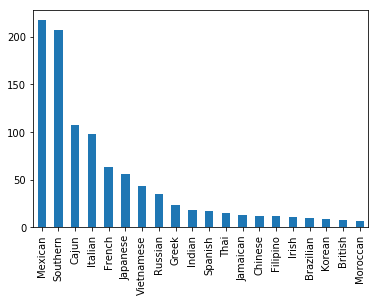

In [35]:
import matplotlib.pyplot as plt
subset = df.cuisine[df.ingredients_string.str.contains('mayo')]
#plot
subset.value_counts().plot(kind='bar')
plt.show()